<a href="https://colab.research.google.com/github/gmazzitelli/studenti/blob/master/showRecoFile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inizializzation.

Runs this part of the script only when you have to init a new machine e and working space

In [31]:
import sys
if 'google.colab' in str(get_ipython()) and sys.version[0:1] in '3':
  print('Running on CoLab env, installing required package')
  !pip install uproot
  !pip install git+https://github.com/DODAS-TS/boto3sts
  !pip install git+https://github.com/CYGNUS-RD/cygno.git
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
import cygno as cy
import os
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import scipy.stats as stats
import os

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

Running on CoLab env, installing required package
  Cloning https://github.com/DODAS-TS/boto3sts to /tmp/pip-req-build-lyyqo7lm
  Running command git clone --filter=blob:none --quiet https://github.com/DODAS-TS/boto3sts /tmp/pip-req-build-lyyqo7lm
  Resolved https://github.com/DODAS-TS/boto3sts to commit c31d511067b3cec93089b2239daf46200392b171
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/CYGNUS-RD/cygno.git to /tmp/pip-req-build-tbhecmg9
  Running command git clone --filter=blob:none --quiet https://github.com/CYGNUS-RD/cygno.git /tmp/pip-req-build-tbhecmg9
  Resolved https://github.com/CYGNUS-RD/cygno.git to commit 73d5a36a5b1233b71f74a30cafae66ed556eab96
  Preparing metadata (setup.py) ... done


Generate data stream file looking for close clusters in any images:

1.   open file recostractued
2.   download dafa file/s [runI] from specifc location [dataSelection]
3.   Serch for cluster with DBSCAN
4.   save output in txt file



In [52]:
start_run=12406
end_run=12407

run_description = False
reco_path0 = 'Gin/'
tag = 'lnf'
rebuild = False

# debug
verbose = False
run_description = None
#
file_out_path = './'
BASE_URL = 'https://s3.cloud.infn.it/v1/AUTH_2ebf769785574195bde2ff418deac08a/'
reco_path = BASE_URL+'cygno-analysis/'+reco_path0
try:
    runSel=runInfo=cy.read_cygno_logbook(sql=True, tag=tag, start_run=start_run, end_run=end_run, verbose=verbose)
    if verbose: print(runInfo)
except Exception as e:
    print('ERROR >>> {}'.format(e))

#runSel = runInfo.loc[runInfo.run_description.str.contains('Stability')]

if run_description:
    runSel = runInfo.loc[runInfo.run_description == run_description]
else:
    runSel = runInfo


for i, run in enumerate(runSel.run_number):

    print("analyzing run: ",run, str(runSel[runSel.run_number==run].run_description.values))

    #
    # caricamento o creazione del file plk
    #
    try:
        branch_data = {}
        parma_data = {}
        file_url = reco_path+'reco_run{:5d}_3D.root'.format(run)
        tf = uproot.open(file_url)
        names = tf["Events;1"].keys()

        for i, name in enumerate(names):
            var = tf["Events;1/"+name].array(library="np")
            if var[0].ndim == 0:
                branch_data[name] = np.hstack(var)
            else:
                branch_data[name] = var
        df = pd.DataFrame(branch_data)

        parma_data['run']=branch_data['run'][0]
        names = tf["Reco_params;1"].keys()
        for i, name in enumerate(names):
            var = tf["Reco_params;1/"+name].array(library="np")
            if name=='Board_PMT':
                c = 0
                for i, b in enumerate(var[0]):
                    c+=2**b
                parma_data[name] = c
            elif name=='fixed_prom':
                parma_data[name] = int(var[0] ==True)
            else:
                parma_data[name] = var

        dp = pd.DataFrame(parma_data)
    except Exception as e:
        print('ERROR >>> {}'.format(e))
        continue

print("DONE")

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'notebook.cygno.cloud.infn.it'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


analyzing run:  12406 ['LabC_FC_V1_slit_trasv_P8_1kV_flux9lh_Th16mV']
DONE


In [33]:
df.columns, dp.columns

(Index(['run', 'event', 'pedestal_run', 'cmos_integral', 'cmos_mean',
        'cmos_rms', 't_DBSCAN', 't_variables', 'lp_len', 't_pedsub',
        't_saturation', 't_zerosup', 't_xycut', 't_rebin', 't_medianfilter',
        't_noisered', 'nSc', 'sc_size', 'sc_nhits', 'sc_integral',
        'sc_corrintegral', 'sc_rms', 'sc_energy', 'sc_pathlength',
        'sc_redpixIdx', 'nRedpix', 'redpix_ix', 'redpix_iy', 'redpix_iz',
        'sc_theta', 'sc_length', 'sc_width', 'sc_longrms', 'sc_latrms',
        'sc_lfullrms', 'sc_tfullrms', 'sc_lp0amplitude', 'sc_lp0prominence',
        'sc_lp0fwhm', 'sc_lp0mean', 'sc_tp0fwhm', 'sc_xmean', 'sc_ymean',
        'sc_xmax', 'sc_xmin', 'sc_ymax', 'sc_ymin', 'sc_pearson',
        'sc_tgaussamp', 'sc_tgaussmean', 'sc_tgausssigma', 'sc_tchi2',
        'sc_tstatus', 'sc_lgaussamp', 'sc_lgaussmean', 'sc_lgausssigma',
        'sc_lchi2', 'sc_lstatus'],
       dtype='object'),
 Index(['run', 'camera_mode', 'rebin', 'nsigma', 'min_neighbors_average',
        'c

In [35]:
dp.camera_mode

0    1
Name: camera_mode, dtype: int32

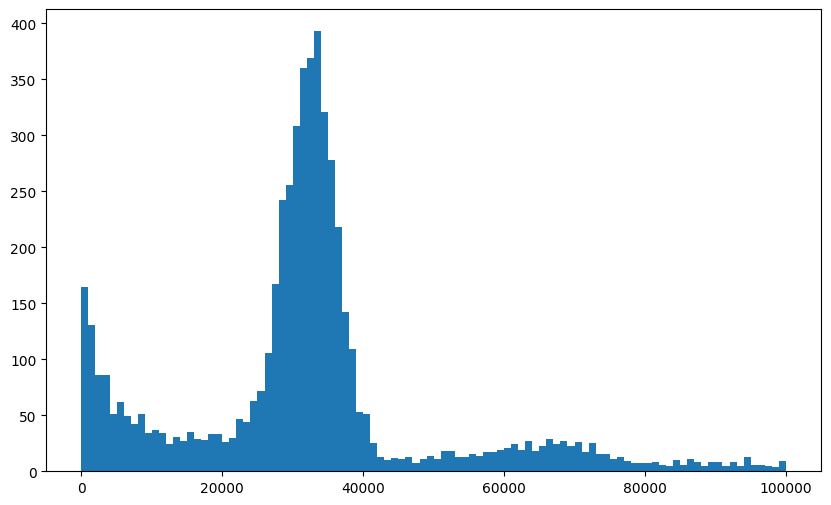

In [53]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(np.hstack(df["sc_integral"])[0:], bins=100, range=(0,1e5))
plt.show()

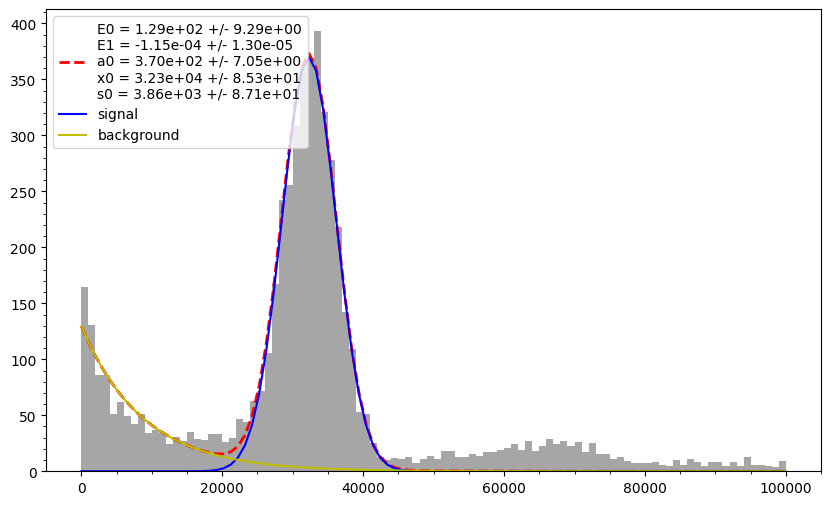

In [51]:
def ExpG(x, p0, p1, a0, x0, s0): # power of ten
    import numpy as np
    return p0*np.exp(p1*x) + a0 * np.exp(-(x - x0)**2 / (2 * s0**2))

def Exp(x, p0, p1): # power of ten
    import numpy as np
    return p0*np.exp(p1*x)

def G3(x, a0, x0, s0): # power of ten
    import numpy as np
    return a0 * np.exp(-(x - x0)**2 / (2 * s0**2))

def myExpG(data, ax, xmin, xmax, bins, E0, E1, a0, x0, s0):
    y = data[(data > xmin) & (data < xmax)]
    binsf = int(bins*((xmax-xmin)/(y.max()-y.min())))
    x=np.linspace(xmin , xmax, binsf)
    yh, _ = np.histogram(y, bins=binsf, range=(xmin,xmax))
    popt, pcov = curve_fit(ExpG, x, yh,
                            p0=(E0, E1, a0, x0, s0))
    #print ("Params: ", popt)
    perr = np.sqrt(np.diag(pcov))
    #print ("err: ", perr)
    # plt.title(r'E0*$e^{(E1*x)}$ + a0*$e^{-\frac{(x - x0)^2}{2*s0^2}}$', fontsize=30)
    ax.plot(x, ExpG(x, *popt), 'r--', linewidth=2,
    label='E0 = %.2e +/- %.2e\nE1 = %.2e +/- %.2e\na0 = %.2e +/- %.2e\nx0 = %.2e +/- %.2e\ns0 = %.2e +/- %.2e' %
                          (popt[0], perr[0],  popt[1],perr[1],
                           popt[2],perr[2], popt[3], perr[3], popt[4], perr[4]))
    ax.plot(x, G3(x, popt[2], popt[3], popt[4]), 'b-', label='signal')
    ax.plot(x, Exp(x, popt[0], popt[1]), 'y-', label='background')
    return ax


bins = 100
xmax = 1e5
xmin = 0

fig, ax = plt.subplots(figsize=(10,6))
myExpG(np.hstack(df['sc_integral']), ax, xmin, xmax, bins, 150., -0.001, 100., 30000., 500.)
ax.hist(np.hstack(df['sc_integral']), bins=bins, range=(xmin,xmax), color='gray', alpha=0.7)


plt.legend(loc=2, prop={'size':'medium'})
plt.minorticks_on()
plt.show()